In [ ]:
# handle missing values
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")
housing_num = housing.select_dtypes(include=[np.number])
imputer.fit(housing_num)
# transform the trainig set
X = imputer.transform(housing_num) 

In [ ]:
# drop outliers
from sklearn.ensemble import IsolationForest

isolation_forest = IsolationForest(random_state=42)
outlier_pred = isolation_forest.fit_predict(X)
housing = housing.iloc[outlier_pred == 1]
housing_labels = housing_labels.iloc[outlier_pred == 1]

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

#ordinal encoding is used for categorical features with ordered categories
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
#check encodied categories
ordinal_encoder.categories_

from sklearn.preprocessing import OneHotEncoder
#one hot encoding is used for categorical features with no ordered categories
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
cat_encoder.categories_

## Feature Scaling

In [12]:
# Import Packages

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import silhouette_score, silhouette_samples,f1_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler,OneHotEncoder,LabelEncoder
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer

import optuna
import scipy.cluster
from sklearn.pipeline import Pipeline

import datetime
import os

from sklearn.model_selection import cross_val_score,train_test_split
from catboost import CatBoostClassifier

from sklearn.feature_selection import SelectKBest, f_classif

In [10]:

dir = './Dataset/'
file_path = os.path.join(dir, 'credit_default.csv')

if os.path.exists(file_path):
    df = pd.read_csv(file_path)
else:
    print("File not found: data.csv")


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   UserID             6000 non-null   object
 1   Sex                6000 non-null   object
 2   PreviousDefault    6000 non-null   int64 
 3   FirstName          6000 non-null   object
 4   LastName           6000 non-null   object
 5   NumberPets         6000 non-null   int64 
 6   PreviousAccounts   6000 non-null   int64 
 7   ResidenceDuration  6000 non-null   int64 
 8   Street             6000 non-null   object
 9   LicensePlate       6000 non-null   object
 10  BadCredit          6000 non-null   int64 
 11  Amount             6000 non-null   int64 
 12  Married            6000 non-null   int64 
 13  Duration           6000 non-null   int64 
 14  City               6000 non-null   object
 15  Purpose            6000 non-null   object
 16  DateOfBirth        6000 non-null   object


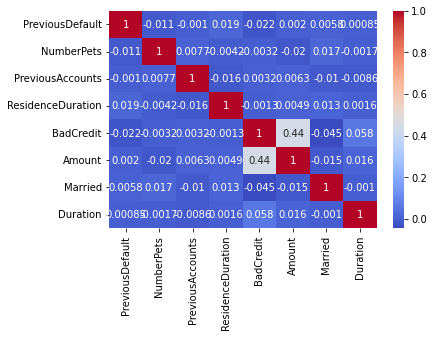

In [6]:
# Correlation Analysis
corr = df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

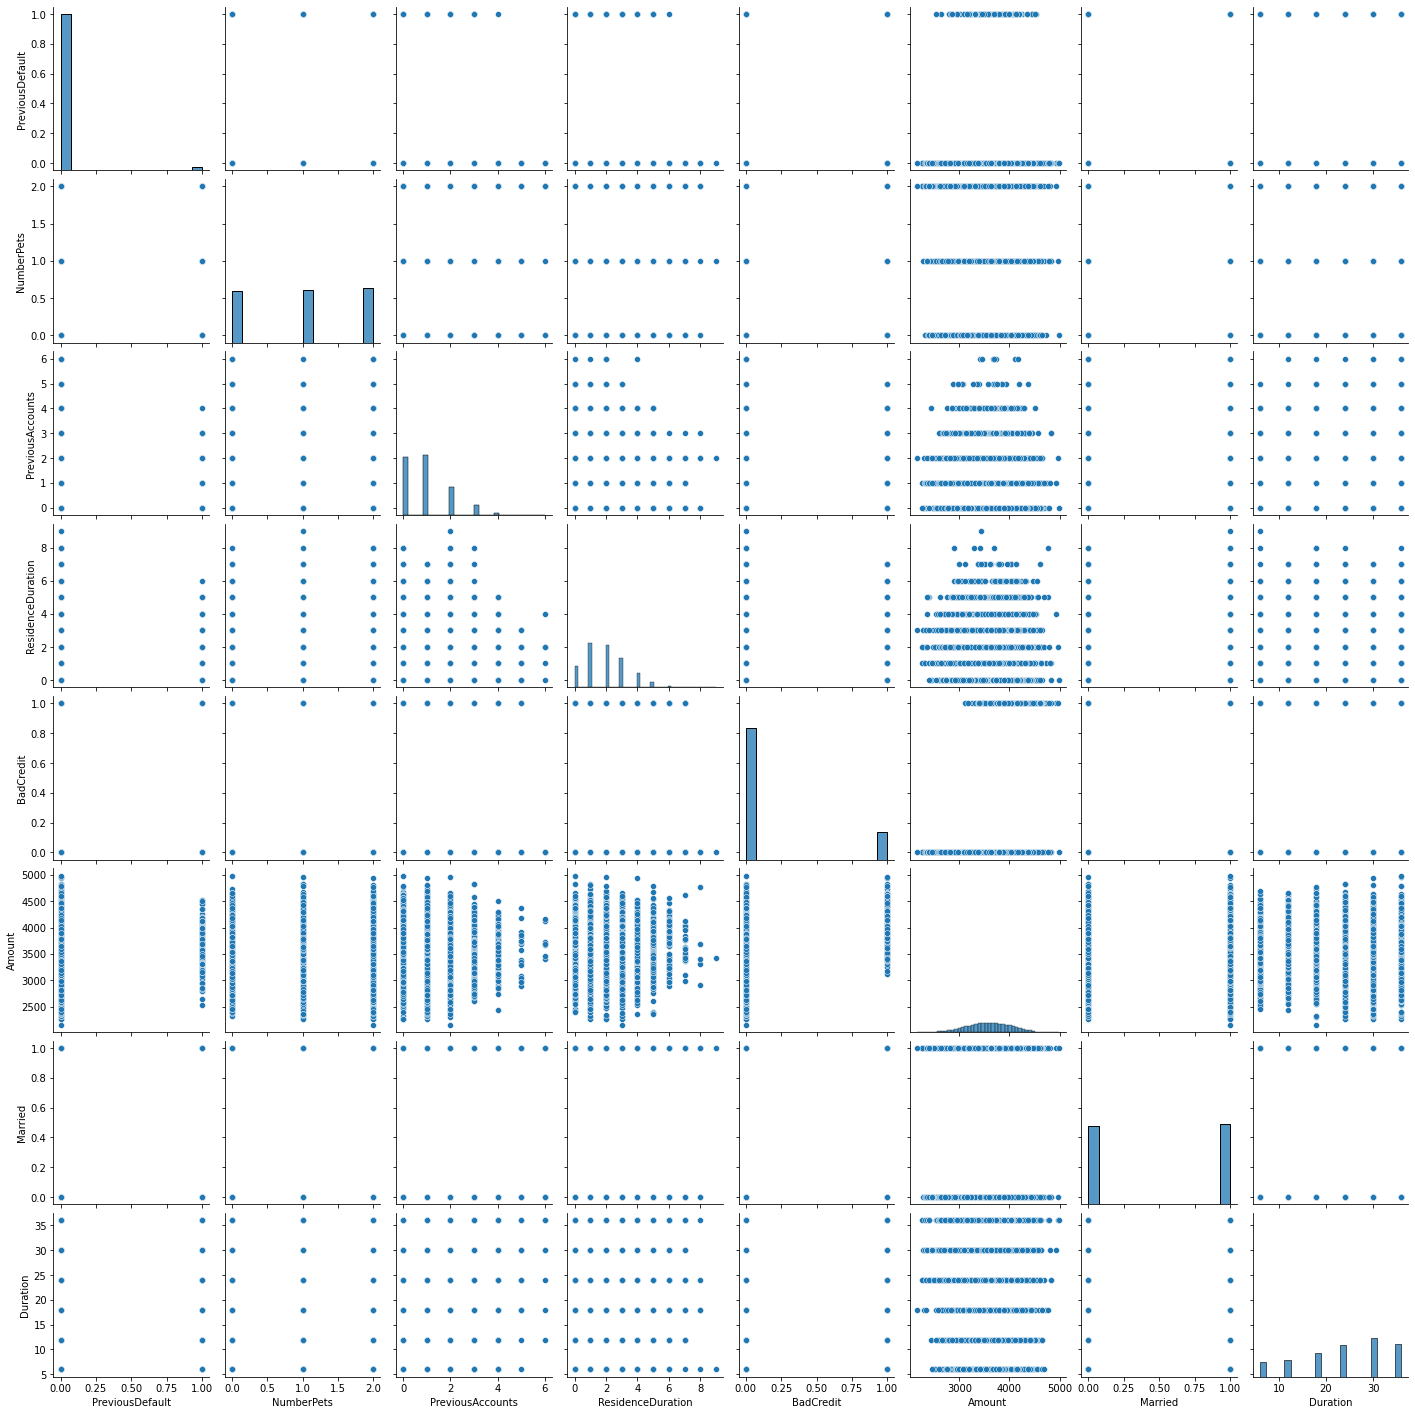

In [7]:
sns.pairplot(df)
plt.show()

In [21]:

X = df.drop('BadCredit', axis=1) #.select_dtypes(['number'])
y = df['BadCredit']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Feature Engineering

Two Features Added:
1. Age baesd on DOB
2. Interaction varaiable based on duration and amount

In [17]:
def feature_eng(df):
  temp_df =df.copy()

  # Add age based on DOB
  today = datetime.datetime.now()
  temp_df['DateOfBirth'] = pd.to_datetime(temp_df['DateOfBirth'])
  # today = datetime.now()
  temp_df['age'] = today.year - temp_df['DateOfBirth'].dt.year
  # interaction varaible
  temp_df['duration_plus_amount'] = temp_df['Duration'] + temp_df['Amount']
  temp_df['duration_minus_amount'] = temp_df['Duration'] - temp_df['Amount']
  temp_df['duration_multi_amount'] = temp_df['Duration'] * temp_df['Amount']
  temp_df['duration_div_amount'] = temp_df['Duration'] / temp_df['Amount']

  return temp_df

In [22]:
X_train = feature_eng(X_train)
X_test = feature_eng(X_test)

## Create a baseline model just to checkout how things are going

In [ ]:
# Columns to drop and to apply one-hot encoding
columns_to_drop = ['UserID','FirstName','LastName','Street','LicensePlate','DateOfBirth','Duration','Amount']
columns_to_encode = ['Sex','City','Purpose']
num_columns =['PreviousDefault', 'NumberPets', 'PreviousAccounts',
       'ResidenceDuration', 'Amount', 'Married', 'Duration', 'age',
       'duration_plus_amount', 'duration_minus_amount',
       'duration_multi_amount', 'duration_div_amount']
# Column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('drop', 'drop', columns_to_drop),
        ('onehot', OneHotEncoder(), columns_to_encode),
        ('scaler', StandardScaler(),num_columns),
    ],
    remainder='passthrough'  # keeps the columns not specified in transformers
)
# Define the CatBoost model
catboost_model = CatBoostClassifier(verbose=False)
# Create pipeline
pipeline_2 = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', catboost_model)])


# Perform cross-validation and then calculate scores
scores = cross_val_score(pipeline_2, X_train, y_train, cv=5,scoring="f1")

# Output the mean accuracy
print(f"Mean CV F1: {scores.mean():.2f}")

In [ ]:
from sklearn.preprocessing import MinMaxScaler
# use a range
min_max_scaler = MinMaxScaler(feature_range=(-1, 1))
housing_num_min_max_scaled = min_max_scaler.fit_transform(housing_num)

from sklearn.preprocessing import StandardScaler
#use mean and std
std_scaler = StandardScaler()
housing_num_std_scaled = std_scaler.fit_transform(housing_num)

# consider using log for power law distributions with long tails or buketize 

In [ ]:
# multinomial features (have multiple peaks), generate new features using rbf kernel
from sklearn.metrics.pairwise import rbf_kernel

age_simil_35 = rbf_kernel(housing[["housing_median_age"]], [[35]], gamma=0.1)